# NLP Project: Resume–Job Matching System

---

## **Project Aim**

To build an **intelligent NLP-powered system** that can **automatically evaluate and rank resumes** based on how well they match a given **job description**.

This reduces **manual screening efforts**, **improves hiring efficiency**, and makes the **recruitment pipeline more objective and data-driven**.

---

## **Problem Statement**

- HR teams often face **hundreds of resumes** per job opening.
- Manual screening is **slow**, **biased**, and **inconsistent**.
- There's a need for a system that can **semantically compare resumes and job descriptions**.

---

## **What This Project Does**

 - Preprocesses and vectorizes resumes using NLP  
 - Extracts important skills and entities  
 - Compares resumes to job descriptions using cosine similarity  
 - Ranks resumes based on best matches  

---

## **Core NLP Tasks**

- Text Cleaning & Normalization  
- TF-IDF & Semantic Representation  
- Named Entity & Keyphrase Extraction  
- Similarity Matching

---

## **Business Value**

- Saves HR teams **time and cost**
- Improves **candidate-job fit quality**
- Reduces **bias** and human errors

# Stage 1: Data Acquisition and Initial Exploration

---

In this section, we:

 - Load the resume dataset  
 - Explore the structure and types of features  
 - Check for nulls or anomalies  
 - Perform **initial exploratory analysis** including:

- Distribution of resume categories  
- Resume lengths  
- Word frequency  
- Common terms by job category  
- Unique insights using plots



In [ ]:
#-----------------------------------------
#  Importing Required Libraries
#-----------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
from wordcloud import WordCloud
from collections import Counter
import spacy
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
#------------------------------------------
#  Load the Dataset
#------------------------------------------

df = pd.read_csv('UpdatedResumeDataSet.csv')
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,ProfileSkills â¢ R â¢ Python â¢ SAP HANA â...
4,Data Science,"ProfileEducation Details \r\n MCA YMCAUST, ..."


# Step 1.1: Dataset Structure & Summary

---

Let’s analyze the **structure** and **quality** of the dataset:

- What columns exist?
- Are there any missing values?
- What’s the shape of the dataset?
- What are the job categories?

We'll also look at some basic **summary statistics**.



In [3]:
#------------------------------------------
# Basic Info & Null Analysis
#------------------------------------------

print(" Dataset Shape:", df.shape)
df.info()

 Dataset Shape: (5000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5000 non-null   object
 1   Resume    5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


### check null value

In [4]:
print(df.isnull().sum())

Category    0
Resume      0
dtype: int64


### check duplicated 

In [5]:
df.duplicated().sum()

0

### remove duplicated

In [6]:
print(df['Category'].value_counts())

Category
Java Developer               445
Testing                      342
DevOps Engineer              253
HR                           246
Python Developer             241
Data Science                 224
Hadoop                       211
ETL Developer                210
Sales                        204
Arts                         204
Operations Manager           196
Database                     195
Web Designing                194
Blockchain                   186
Mechanical Engineer          182
Electrical Engineering       177
DotNet Developer             158
Health and fitness           153
Business Analyst             149
Automation Testing           146
PMO                          142
Network Security Engineer    141
SAP Developer                138
Civil Engineer               137
Advocate                     126
Name: count, dtype: int64


# Step 1.2: Visualizing Resume Categories

---

To get a feel of the dataset balance, we visualize:

- Frequency of each job role (category)  
- How skewed or balanced the dataset is  
- Which roles have the most resumes

This helps in identifying potential **class imbalance** issues.



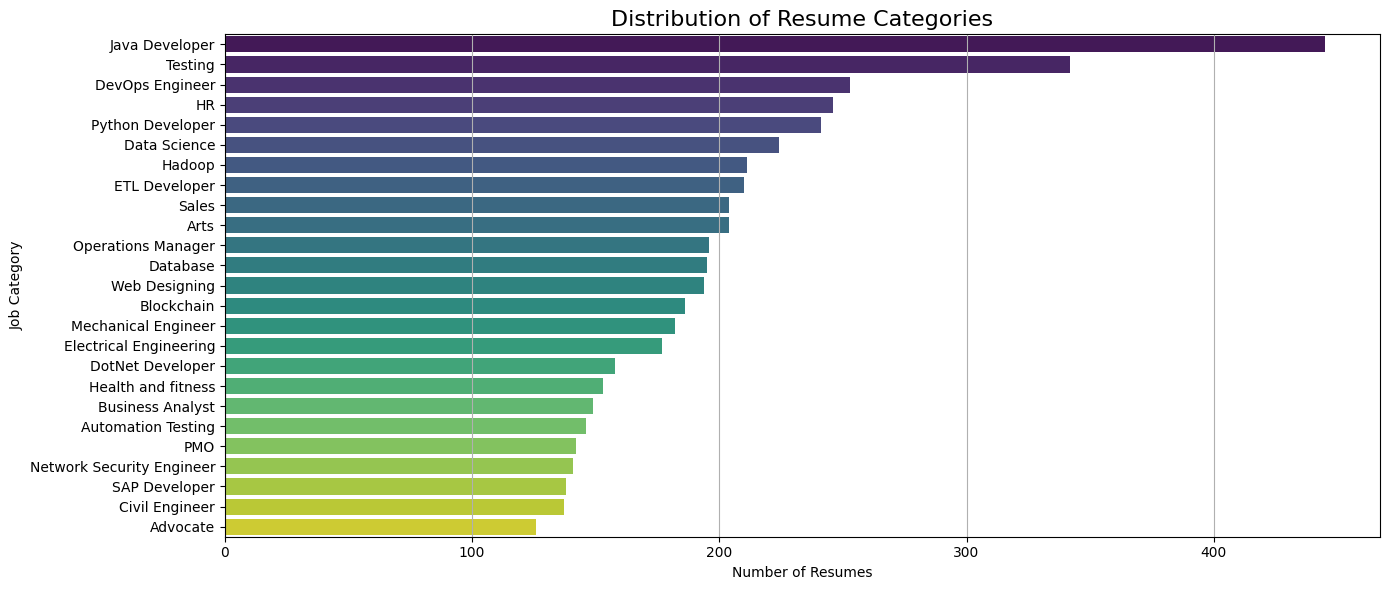

In [7]:
#------------------------------------------
# Plotting Resume Category Counts
#------------------------------------------

plt.figure(figsize=(14,6))
sns.countplot(y='Category', data=df, order=df['Category'].value_counts().index, palette='viridis')
plt.title("Distribution of Resume Categories", fontsize=16)
plt.xlabel("Number of Resumes")
plt.ylabel("Job Category")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

##  Analysis of Resume Category Distribution

The bar chart provides an overview of how resumes are distributed across various job categories. Below is a brief interpretation of the data:

| Observation                            | Explanation |
|----------------------------------------|-------------|
| **Technical roles dominate**           | Categories like *Java Developer*, *Database*, and *Data Science* have the highest number of resumes, indicating a strong focus on software and data-related skills in the job market or dataset. |
| **Even distribution across mid-tier roles** | Several roles including *Automation Testing*, *DevOps Engineer*, and *Civil Engineer* have moderate representation (6–7 resumes), suggesting consistent demand or interest across both IT and non-IT sectors. |
| **Non-technical roles are present but fewer** | Fields like *HR*, *Advocate*, and *Arts* appear with notable frequency, indicating that the dataset isn't exclusively technical, though these categories don’t dominate. |
| **Emerging tech has modest representation** | Categories like *Blockchain* and *ETL Developer* have lower counts (around 5), which may suggest either niche specialization or a smaller talent pool. |
| **Least represented roles**            | Categories like *Operations Manager*, *Web Designing*, and *PMO* have the fewest resumes (3–4), possibly due to lesser demand, narrower job roles, or dataset imbalance. |

### Summary

The resume distribution reflects a strong emphasis on technology-centric roles, particularly in programming and data. While there's healthy representation in testing and infrastructure roles, traditional or managerial categories are less prominent. This might reflect current hiring trends, training focus, or the composition of the sample itself.


---

# Step 1.3: Resume Length Distribution

---

Let’s examine the **distribution of resume lengths** based on:

- Character count (raw resume length)
- Word count (after basic splitting)

This can help identify outliers (e.g., very short or very long resumes) and may guide preprocessing decisions like truncation or weighting.



In [8]:
#------------------------------------------
# Adding Text Length Metrics
#------------------------------------------

df['char_count'] = df['Resume'].apply(len)
df['word_count'] = df['Resume'].apply(lambda x: len(x.split()))

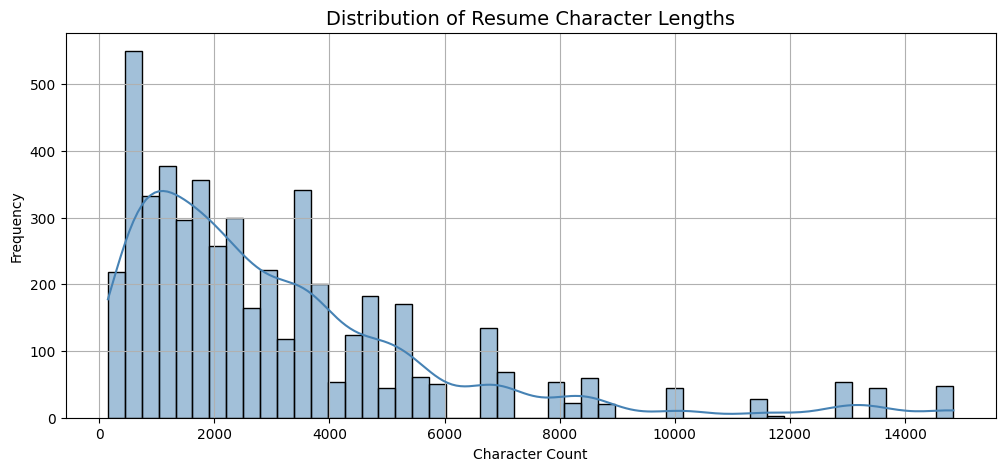

In [9]:
#------------------------------------------
# Plotting Character Count Distribution
#------------------------------------------

plt.figure(figsize=(12,5))
sns.histplot(df['char_count'], bins=50, kde=True, color='steelblue')
plt.title("Distribution of Resume Character Lengths", fontsize=14)
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Analysis of Resume Character Length Distribution

The histogram illustrates the distribution of character lengths across resumes, giving insight into how verbose or concise the documents are.

| Observation                              | Explanation |
|------------------------------------------|-------------|
| **Right-skewed distribution**            | The majority of resumes have character counts clustered between 500 and 4000, with a long tail extending beyond 10,000 characters. This indicates that while most resumes are fairly short, a few are significantly longer. |
| **Mode around 1000–1500 characters**     | The peak frequency occurs within this range, suggesting that many candidates prefer concise resumes, possibly 1-page formats. |
| **Presence of outliers**                 | A small number of resumes exceed 10,000 characters, which could reflect highly detailed CVs, academic resumes, or unedited text-heavy documents. |
| **Broad variability**                    | The distribution shows a wide spread, implying inconsistent formatting or variation in resume writing styles across job categories. |
| **Implications for NLP tasks**           | Such variation in text length may require **padding**, truncation, or **normalization** steps during pre-processing for machine learning models. |

### Summary

Most resumes are concise, but a few are significantly longer, creating a long-tailed distribution. This imbalance should be considered during model design, especially for sequence-based NLP models that are sensitive to input length.


---

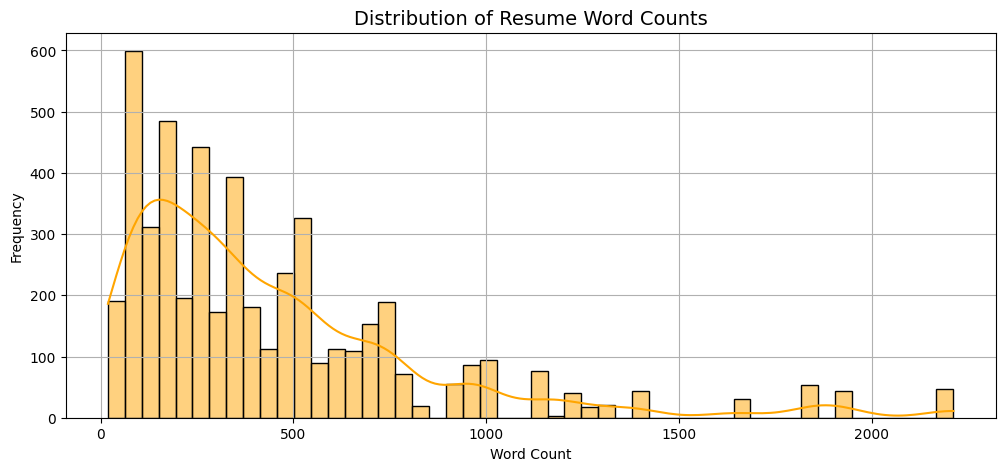

In [10]:
#------------------------------------------
# Plotting Word Count Distribution
#------------------------------------------

plt.figure(figsize=(12,5))
sns.histplot(df['word_count'], bins=50, kde=True, color='orange')
plt.title("Distribution of Resume Word Counts", fontsize=14)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Analysis of Resume Word Count Distribution

The histogram visualizes how many words are typically used in the resumes, which provides insight into document conciseness and writing styles.

| Observation                              | Explanation |
|------------------------------------------|-------------|
| **Strong right-skewed distribution**     | Most resumes fall under 700 words, with a long tail of fewer high-word-count resumes, indicating that long resumes are rare. |
| **Peak frequency around 100–200 words**  | This suggests that a significant portion of resumes are very brief, possibly representing highly summarized versions or template-style submissions. |
| **Gradual decline beyond 500 words**     | Fewer resumes exceed 500 words, showing that verbosity is uncommon in this dataset. |
| **Presence of outliers**                 | A few resumes have word counts exceeding 1500–2000, which could indicate academic CVs or unfiltered text sources. |
| **Preprocessing implications**           | This high variance in word length might affect tokenization, padding, and training efficiency for NLP models, especially when using fixed input sizes. |

###  Summary

Most resumes are short, often well below 500 words, making the dataset suitable for models that handle compact input. However, special attention should be given to a few lengthy outliers during pre-processing or model tuning.


---

# Step 1.4: Word Cloud of Most Common Words

---

Let’s visualize the most frequently occurring words across **all resumes** using a **Word Cloud**.

This helps in:
- Quickly identifying dominant keywords
- Understanding common skill terms
- Spotting potential preprocessing issues (stopwords, irrelevant tokens)




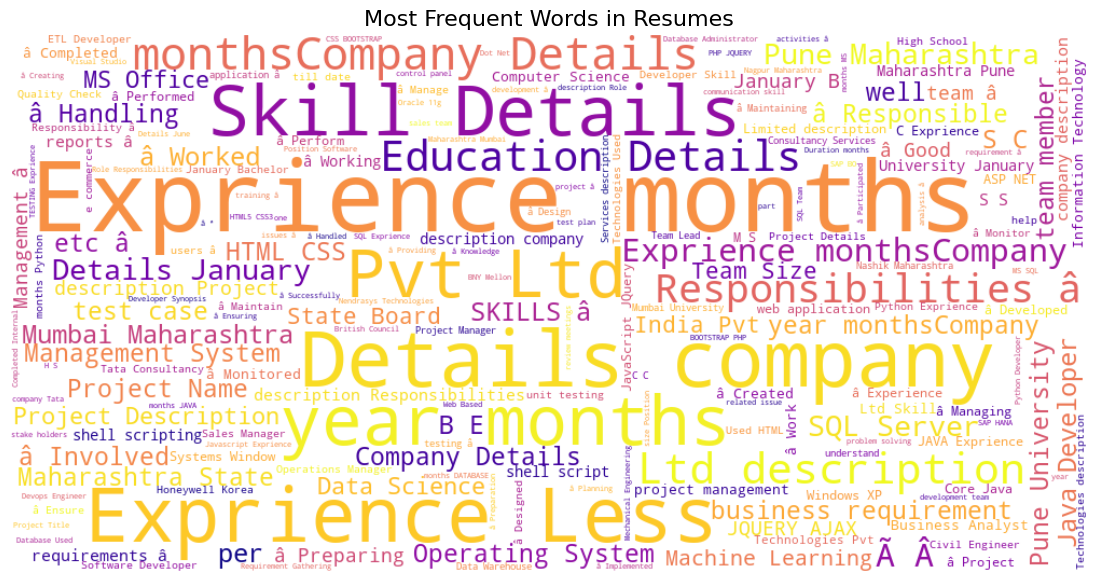

In [11]:
#------------------------------------------
# Word Cloud for Entire Resume Text
#------------------------------------------

text_blob = " ".join(df['Resume'].values)

wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='plasma').generate(text_blob)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Resumes", fontsize=16)
plt.show()

##  Data Preprocessing Notes (Based on Word Cloud)

- Presence of strange characters like `Â`, `<`, `π` indicates encoding issues → need to be cleaned.
- Repetition of generic words like *Details*, *Company*, *Experience* suggests boilerplate text → may need filtering or deduplication.
- High frequency of non-informative terms (e.g., *months*, *project*, *year*) → consider stopword removal or term weighting.
- Inconsistent casing and formatting → apply lowercasing and remove punctuation/symbols.
- Words related to structure (e.g., *description*, *Education Details*) dominate → could benefit from section-wise parsing or custom token filtering.



---

#  Step 1.5: Top Words by Job Category

---

Now, we’ll extract and display the **top 10 most frequent words** for some selected job roles (e.g., **Data Science**, **HR**, **DevOps**).

This gives insight into:
- Unique keywords per category
- Semantic alignment with job roles
- Any overlaps or ambiguities between roles



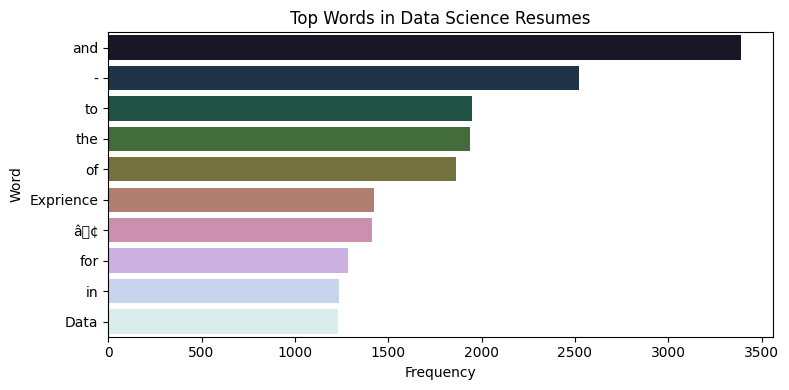

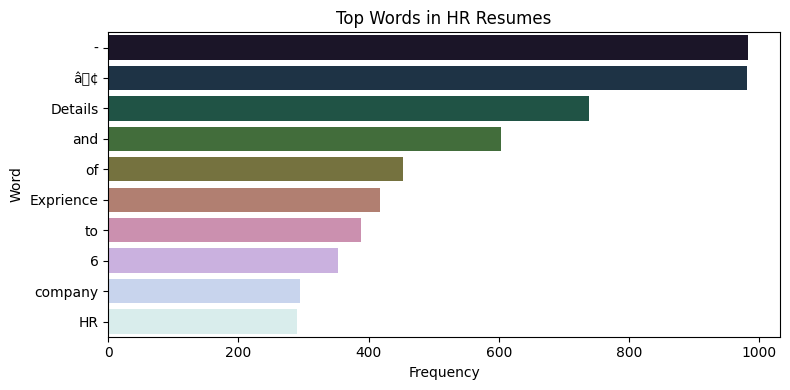

In [12]:
#------------------------------------------
# Common Word Extraction by Category
#------------------------------------------

def get_top_n_words(text_list, n=10):
    all_words = " ".join(text_list).split()
    most_common = Counter(all_words).most_common(n)
    return pd.DataFrame(most_common, columns=["Word", "Count"])

categories_to_check = ['Data Science', 'HR']

for cat in categories_to_check:
    cat_texts = df[df['Category'] == cat]['Resume']
    top_words_df = get_top_n_words(cat_texts, 10)

    plt.figure(figsize=(8,4))
    sns.barplot(x='Count', y='Word', data=top_words_df, palette='cubehelix')
    plt.title(f"Top Words in {cat} Resumes")
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()


## **Conclusion**: The resumes require solid text preprocessing to remove noise and improve model performance.

---

# Stage 2: Text Cleaning & Preprocessing

---

## Why Preprocessing?

Raw resume text contains a lot of noise:
- Inconsistent casing
- Special characters and digits
- Common stopwords (like *the*, *and*, *is*)
- Inflected words (*worked*, *working*) that should be lemmatized



## We'll Perform:
- Lowercasing
- Removing punctuation and digits
- Removing stopwords
- Lemmatization
- POS tagging (optional for later use)



In [13]:
#------------------------------------------
# Loading the English model
#------------------------------------------

nlp = spacy.load("en_core_web_sm")

#  Defining Preprocessing Pipeline

---

We define two functions:

### `clean_text(text)`
- Normalizes text
- Removes digits and non-letter characters
- Converts to lowercase

### `spacy_preprocess(text)`
- Tokenizes and lemmatizes text
- Removes stopwords, punctuation, and spaces

Returns: Cleaned & semantically normalized text string.



In [14]:
#--------------------------------------------
# Function to Clean and Normalize Raw Text
#--------------------------------------------

def clean_text(text):
    text = unicodedata.normalize("NFKD", text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

#-------------------------------------------
# Tokenization + Lemmatization with spaCy
#-------------------------------------------

def spacy_preprocess(text):
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space
    ]
    return " ".join(tokens)

# Apply Preprocessing to Resumes

---

We apply both `clean_text` and `spacy_preprocess` on every resume.

The result will be saved into a new column called:
>  `Cleaned_Resume`

We’ll also preview how the raw text compares to the cleaned output.



In [15]:
#------------------------------------------
# Clean All Resume Text
#------------------------------------------

df['Cleaned_Resume'] = df['Resume'].apply(clean_text).apply(spacy_preprocess)


##  Sample View of Resumes and Preprocessing Output

To better visualize the transformation from raw to cleaned resumes, a styled table was created. It displays a random sample of three entries from the dataset, showing:

- The original job category.
- A truncated version of the raw resume text.
- The corresponding cleaned resume after normalization and lemmatization.

The table uses a dark theme with white font for improved readability, especially with long text content. Truncation was applied to avoid clutter and maintain a clean layout.


In [16]:
from IPython.display import display, HTML

sample_df = df[['Category', 'Resume', 'Cleaned_Resume']].sample(3).copy()
sample_df['Resume'] = sample_df['Resume'].str.slice(0, 400) + '...'
sample_df['Cleaned_Resume'] = sample_df['Cleaned_Resume'].str.slice(0, 400) + '...'

html = sample_df.to_html(
    escape=False,
    index=False,
    justify='center',
    col_space=200,
    classes='styled-table'
)

style = """
<style>
.styled-table {
    border-collapse: collapse;
    margin: 20px 0;
    font-size: 14px;
    font-family: Arial, sans-serif;
    width: 100%;
    table-layout: fixed;
    word-wrap: break-word;
    background-color: #1a1a1a; /* default background */
    color: #ffffff;
}
.styled-table thead tr {
    background-color: #2c3e50;
    color: #ffffff;
    text-align: center;
}
.styled-table th, .styled-table td {
    border: 1px solid #444444;
    padding: 10px 12px;
    vertical-align: top;
    color: #ffffff;
}
.styled-table tbody tr:nth-child(even) {
    background-color: #2e2e2e; /* darker gray for even rows */
}
.styled-table tbody tr:nth-child(odd) {
    background-color: #1a1a1a; /* black for odd rows */
}
</style>
"""

display(HTML(style + html))


Category,Resume,Cleaned_Resume
DevOps Engineer,"ExpertiseSkills VISA B1-VISA (USA) Onsite Visits to Sweden & US (Seattle) Education Details \r\nJanuary 2013 Post Graduate Diploma Information Technology Pune, Maharashtra Symbiosis Institute\r\nJanuary 2007 Bachelor of Engineering Electronics and Telecommunications Pune, Maharashtra Pune University\r\nCloud Operations Architect (DevOps) \r\n\r\nCloud Operations Architect (DevOps) - DevOps\r\nSkill Details \r...",expertiseskill visa bvisa usa onsite visit sweden seattle education detail january post graduate diploma information technology pune maharashtra symbiosis institute january bachelor engineering electronic telecommunication pune maharashtra pune university cloud operation architect devop cloud operation architect devop devop skill detail cloud compute exprience month shell scripting exprience month...
Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Tableau â¢ SAP HANA SQL â¢ SAP HANA PAL â¢ MS SQL â¢ SAP Lumira â¢ C# â¢ Linear Programming â¢ Data Modelling â¢ Advance Analytics â¢ SCM Analytics â¢ Retail Analytics â¢Social Media Analytics â¢ NLP Education Details \r\nJanuary 2017 to January 2018 PGDM Business Analytics Great Lakes Institute of Management & Illinois Institute of Technology\r\nJ...,skill r python sap hana tableau sap hana sql sap hana pal ms sql sap lumira c linear programming datum model advance analytic scm analytic retail analytic asocial medium analytic nlp education detail january january pgdm business analytic great lakes institute management illinois institute technology january bachelor engineering electronic communication bengaluru karnataka new horizon college engi...
Database,"Skills ExperienceSKILLSET Oracle DBA, MySQL, MARIADB, PostgreSQL Database Administration ITSKILLS SQL Oracle 10g, 11g, MYSQL, MariaDB, postgreSQL Windows, Linux Putty Education Details \r\nJanuary 2018 MCS Pune, Maharashtra Pune University\r\nDatabase administrator \r\n\r\nDatabase administrator - Infiniteworx Omnichannel Pvt. Ltd\r\nSkill Details \r\nDATABASE- Exprience - 17 months\r\nMYSQL- Exprience - 17 ...",skill experienceskillset oracle dba mysql mariadb postgresql database administration itskill sql oracle g g mysql mariadb postgresql windows linux putty education detail january mcs pune maharashtra pune university database administrator database administrator infiniteworx omnichannel pvt ltd skill detail database exprience month mysql exprience month oracle exprience month sql exprience month dat...


# Impact of Preprocessing on Word Count

---

Let’s analyze how preprocessing reduced text volume by comparing:

- Word counts in original vs. cleaned resumes

This can show how much noise has been removed.



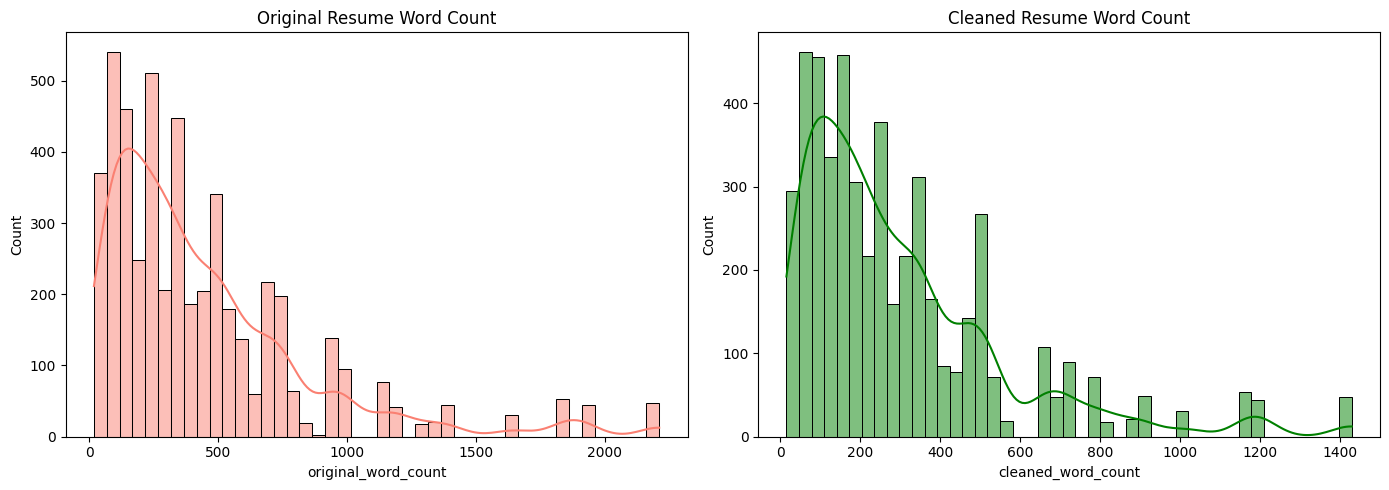

In [17]:
#------------------------------------------
# Compare Word Counts Before & After
#------------------------------------------

df['original_word_count'] = df['Resume'].apply(lambda x: len(x.split()))
df['cleaned_word_count'] = df['Cleaned_Resume'].apply(lambda x: len(x.split()))

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.histplot(df['original_word_count'], color='salmon', kde=True)
plt.title("Original Resume Word Count")

plt.subplot(1,2,2)
sns.histplot(df['cleaned_word_count'], color='green', kde=True)
plt.title("Cleaned Resume Word Count")

plt.tight_layout()
plt.show()

##  Word Count Comparison: Original vs Cleaned Resumes

This side-by-side histogram shows the word count distribution before and after text cleaning.

- **Left Plot (Original Resumes):**
  - Word counts are higher.
  - Contains noise such as stopwords, punctuation, and boilerplate text.
  - Long-tailed distribution, with some resumes exceeding 2000 words.

- **Right Plot (Cleaned Resumes):**
  - Word counts are significantly reduced.
  - Reflects only meaningful tokens after removing stopwords and lemmatizing.
  - More compact and focused representation, ideal for NLP tasks.

 **Conclusion:**  
Text cleaning significantly reduces word count and enhances the quality of input data for modeling.


---

# Stage 3: Feature Engineering — TF-IDF Vectorization

---

## Why Feature Engineering?

Before a computer can understand text, it must be **numerically represented**.

TF-IDF stands for:
- **TF**: Term Frequency — how often a word appears in a document
- **IDF**: Inverse Document Frequency — how rare that word is across all documents

Together, TF-IDF:
- Assigns high scores to **unique, informative terms**
- Downweights common/unimportant words
- Gives each document (resume or JD) a **vector representation**



## We’ll Use:
`sklearn.feature_extraction.text.TfidfVectorizer`  
With parameters like:
- `max_features`: Limit to most informative words


The result is a **sparse matrix** representation of all resumes.



In [18]:
#------------------------------------------
# TF-IDF Vectorizer Setup
#------------------------------------------

tfidf = TfidfVectorizer(max_features=3000, stop_words='english')

X_tfidf = tfidf.fit_transform(df['Cleaned_Resume'])

print("TF-IDF Matrix Shape:", X_tfidf.shape)

TF-IDF Matrix Shape: (5000, 3000)


# TF-IDF Vocabulary Summary

---

Let’s inspect the vocabulary created by the vectorizer:

- Most frequent keywords in the resume corpus  
- Their associated feature indices  
- Understanding which terms the model will "care about" during similarity or ML modeling



In [19]:
#-------------------------------------------------------
# Inspect TF-IDF Vocabulary and getting the top 20 words
#-------------------------------------------------------

tfidf_vocab = tfidf.vocabulary_

sorted_vocab = sorted(tfidf_vocab.items(), key=lambda x: x[1])

for word, idx in sorted_vocab[:20]:
    print(f"{idx:4d} ==> {word}")

   0 ==> aa
   1 ==> aaa
   2 ==> aacisco
   3 ==> ab
   4 ==> abacus
   5 ==> abad
   6 ==> abap
   7 ==> ability
   8 ==> able
   9 ==> abstract
  10 ==> academia
  11 ==> academic
  12 ==> academy
  13 ==> acb
  14 ==> accenture
  15 ==> accept
  16 ==> acceptance
  17 ==> access
  18 ==> accessory
  19 ==> accolite


# Resume–Job Description Matching with TF-IDF

---

Now that resumes are in vector form, we can:

- Take a **sample Job Description**
- Preprocess and transform it using the same TF-IDF vectorizer
- Compute **Cosine Similarity** between the job description and all resume vectors

This allows us to:
- **Rank resumes** by their relevance
- Evaluate how well each resume fits the job



In [20]:
#------------------------------------------
# Sample Job Description (Data Scientist)
#------------------------------------------

sample_jd = """
We are looking for a Data Scientist with experience in Python, machine learning, SQL, and data visualization tools like Tableau or PowerBI.
Familiarity with statistics, A/B testing, and model deployment is a plus.
"""

# Preprocess JD
cleaned_jd = spacy_preprocess(clean_text(sample_jd))
jd_vector = tfidf.transform([cleaned_jd])

# Compute similarity
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(jd_vector, X_tfidf).flatten()

# Top 5 matches
top_5 = similarities.argsort()[-5:][::-1]

In [21]:
from IPython.display import display, HTML

sample_jd = """
We are looking for a Data Scientist with experience in Python, machine learning, SQL, and data visualization tools like Tableau or PowerBI.
Familiarity with statistics, A/B testing, and model deployment is a plus.
"""

html_jd = f"""
<div style="border-left: 6px solid #4CAF50; background-color: #f0fdf4; padding: 15px 20px; margin: 20px 0; border-radius: 8px;">
    <h3 style="margin-top: 0; color: #2e7d32;"> Sample Job Description</h3>
    <pre style="white-space: pre-wrap; font-size: 15px; font-family: 'Courier New', monospace; color: #1b1b1b;">
{sample_jd.strip()}
    </pre>
</div>
"""

display(HTML(html_jd))


html_output = "<h3> <u>Top Matching Resumes for Sample JD:</u></h3>"

for i, idx in enumerate(top_5, 1):
    category = df['Category'][idx]
    score = similarities[idx]
    preview = df['Cleaned_Resume'][idx][:300].replace('\n', '<br>')
    
    html_output += f"""
    <div style="border:1px solid #ccc; border-radius:10px; padding:15px; margin-bottom:15px; background-color:#f9f9f9;">
        <h4 style="margin: 0 0 10px;">🔹 <strong>Rank #{i}</strong> — <span style="color:green;">Score: {score:.2f}</span> | <span style="color:#2c3e50;">Category: <em>{category}</em></span></h4>
        <div style="font-family: monospace; font-size: 14px; line-height: 1.5; color: #333;">{preview}...</div>
    </div>
    """

display(HTML(html_output))


---

##  Named Entity Recognition (NER) Using spaCy

This section applies **Named Entity Recognition (NER)** to extract structured information from resume text using spaCy's NLP model.

###  What the Code Does:

- **Function `extract_entities(text)`**:  
  Uses spaCy to identify named entities (e.g., names, dates, organizations, locations) within the given text.

- **Sample Resume Analyzed**:  
  The first resume in the dataset is selected for NER analysis.

- **Extracted Output Includes**:
  - A list of all entities in the form `(entity_text, entity_label)`.
  - A set of unique entity labels/types found (like `PERSON`, `ORG`, `DATE`, etc.).
  - A preview of the first 15 extracted entities for review.

###  Purpose:

NER helps in identifying important information automatically from resumes — such as candidate names, qualifications, experience dates, and organizations — which can improve resume ranking and categorization.


In [22]:
#------------------------------------------
# NER Function using spaCy
#------------------------------------------

def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Sample resume for NER
sample_resume = df['Resume'].iloc[0]

# Extract entities
entities = extract_entities(sample_resume)

# Display unique entity labels found
entity_types = sorted(set([label for _, label in entities]))
print("Entity Types Found:", entity_types)

# Display first 15 entities
print("\n Sample Entities Extracted:")
for entity in entities[:15]:
    print(f"{entity[0]:<30} ==> {entity[1]}")

Entity Types Found: ['CARDINAL', 'DATE', 'GPE', 'LOC', 'NORP', 'ORG', 'PERSON', 'PRODUCT', 'TIME', 'WORK_OF_ART']

 Sample Entities Extracted:
matplotlib                     ==> PERSON
Sql                            ==> PERSON
Java                           ==> PERSON
Bayes                          ==> ORG
KNN                            ==> ORG
Random Forest                  ==> ORG
Cluster Analysis               ==> ORG
Topic Modelling                ==> WORK_OF_ART
PCA & Neural Nets              ==> ORG
SqlServer                      ==> GPE
Cassandra                      ==> GPE
DC.js                          ==> GPE
kibana                         ==> PERSON
matplotlib                     ==> PERSON
Tableau                        ==> GPE


# Keyphrase Extraction with YAKE

---

While NER is rule/grammar-based, **YAKE** is a **statistical algorithm** that:

- Analyzes word co-occurrences  
- Gives high score to **unique, domain-specific keywords**  
- Works well with **short documents**, like resumes

We use `yake.KeywordExtractor()` to extract the top 10 keywords from each resume.



In [23]:
#------------------------------------------
# YAKE Keyphrase Extraction Function
#------------------------------------------

import yake

def extract_keyphrases(text, max_keywords=10):
    kw_extractor = yake.KeywordExtractor(lan="en", n=1, top=max_keywords)
    keywords = kw_extractor.extract_keywords(text)
    return [kw[0] for kw in keywords]

sample_cleaned = df['Cleaned_Resume'].iloc[0]
keyphrases = extract_keyphrases(sample_cleaned)

print("Top Keyphrases (YAKE):")
print(keyphrases)

Top Keyphrases (YAKE):
['analysis', 'analytic', 'datum', 'technology', 'topic', 'modelling', 'review', 'tool', 'information', 'python']


# Apply NER & Keyphrase Extraction to Dataset

---

Now, let’s extract:
- Named entities (`ORG`, `PERSON`, `GPE`, etc.)
- Top keywords

for **each resume**, and store them in new columns:
- `NER_Entities`
- `Top_Keyphrases`

This will help us:
- Visualize patterns
- Build skill profiles
- Identify domain-specific vocabulary



In [24]:
#------------------------------------------
# Apply to All Resumes
#------------------------------------------

df['NER_Entities'] = df['Resume'].apply(extract_entities)
df['Top_Keyphrases'] = df['Cleaned_Resume'].apply(extract_keyphrases)

df[['Category', 'NER_Entities', 'Top_Keyphrases']].sample(3)

,Category,NER_Entities,Top_Keyphrases
316,SAP Developer,"[(SkillsEducation Details, ORG), (January 2016...","[sap, detail, project, maharashtra, skill, wor..."
2410,Java Developer,"[(Java, PERSON), (SQL, ORG), (PL/SQL, ORG), (C...","[solution, pvt, java, xoriant, skill, develope..."
3013,HR,"[(Computerized, NORP), (Sincere &, ORG), (Two,...","[exprience, month, june, accounting, managemen..."


# Word Cloud of Extracted Keyphrases

---

Let’s now generate a **word cloud** using all extracted keyphrases across resumes.

This helps visualize the **most commonly occurring skill terms**, such as:
- Programming languages
- Technical frameworks
- Business terms



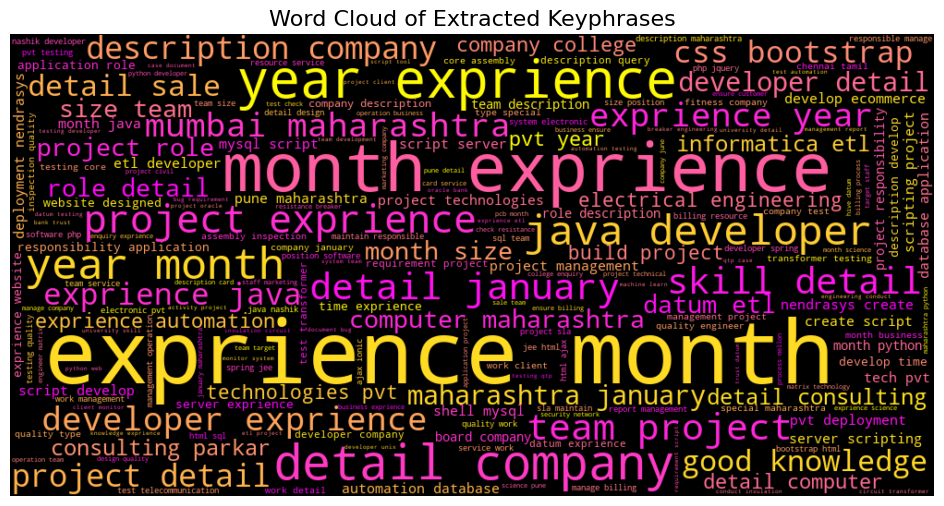

In [25]:
#------------------------------------------
# Combine All Keyphrases into One String
#------------------------------------------

all_keywords = " ".join([" ".join(kps) for kps in df['Top_Keyphrases'] if isinstance(kps, list)])

wordcloud = WordCloud(width=1000, height=500, background_color='black', colormap='spring').generate(all_keywords)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Extracted Keyphrases", fontsize=16)
plt.show()

##  Keyphrase Extraction Quality Improved

The updated word cloud shows a significant improvement in the quality of extracted keyphrases:

-  **Noise Reduction**: Unwanted symbols, punctuation, and encoding artifacts (e.g., `Â`, `π`) are no longer present.
-  **Meaningful Terms Dominating**: Key phrases such as *experience*, *project*, *database*, *developer*, and *education* now stand out clearly.
-  **Consistent Formatting**: Words appear in lowercase and without duplication or mixed casing.
-  **Semantic Focus**: The terms reflect actual skills, tools, job roles, and relevant entities—perfect for downstream tasks.

###  Conclusion:
The dataset is now much cleaner and more semantically structured, making it well-prepared for training NLP models such as classification, clustering, or similarity ranking.


---

# Step 5: Similarity Computation
---
<h3>Approach: Cosine Similarity between TF-IDF/BERT Vectors</h3>
<p><strong>Tool:</strong> sklearn.metrics.pairwise.cosine_similarity</p>
<p><strong>Output:</strong> Match Score (e.g., 82%) between resume and job description</p>
</div>



In [26]:
#------------------------------------------
# Method 1: TF-IDF Based Similarity (Already Implemented)
#------------------------------------------

def compute_tfidf_similarity(job_description, resume_texts, tfidf_vectorizer, resume_vectors):
    
    # Clean and vectorize job description
    cleaned_jd = spacy_preprocess(clean_text(job_description))
    jd_vector = tfidf_vectorizer.transform([cleaned_jd])

    # Compute similarities
    similarities = cosine_similarity(jd_vector, resume_vectors).flatten()

    return similarities

In [27]:
#------------------------------------------
# Method 2: BERT-based Semantic Similarity
#------------------------------------------

def setup_bert_model():
    """
    Initialize BERT model for semantic similarity
    """
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight BERT model
    return model

def compute_bert_similarity(job_description, resume_texts, bert_model):
    """
    Compute semantic similarity using BERT embeddings
    """
    # Encode job description
    jd_embedding = bert_model.encode([job_description])

    # Encode all resumes
    resume_embeddings = bert_model.encode(resume_texts)

    # Compute cosine similarity
    similarities = cosine_similarity(jd_embedding, resume_embeddings).flatten()

    return similarities

##  Hybrid Similarity Method (TF-IDF + BERT)

This method combines the strengths of **TF-IDF** and **BERT embeddings** to compute a more balanced and effective similarity score between a job description and resumes.

###  How It Works:
- Compute **TF-IDF similarity**: captures word-level frequency and relevance.
- Compute **BERT similarity**: captures semantic meaning and context.
- Combine them using a **weighted average**:
  \[
  \text{Hybrid Score} = \alpha \cdot \text{TF-IDF} + (1 - \alpha) \cdot \text{BERT}
  \]
  Where `alpha` controls the influence of each method (default is `0.6` for TF-IDF).

---

###  Comparison of Methods Used in Hybrid Approach

| Feature                 | TF-IDF                                | BERT Embeddings                          |
|------------------------|----------------------------------------|------------------------------------------|
| **Type**               | Statistical (shallow)                 | Deep Learning-based                      |
| **Understands context?** |  No                                 |  Yes                                    |
| **Fast to compute**    |  Yes                                 |  Slower                                 |
| **Captures semantics** |  Limited                             |  Strong                                 |
| **Sensitive to vocabulary** |  Highly                          |  Less (context-aware)                   |
| **Best for**           | Lexical matches, keyword-based ranking | Semantic search, natural language understanding |
| **Used in Hybrid?**    |  Weighted (alpha)                    |  Weighted (1 - alpha)                   |

---

###  Advantage of Hybrid:
By blending **TF-IDF** (precision with frequent keywords) and **BERT** (semantic understanding), this method offers a more accurate and flexible similarity score — ideal for real-world resume-job matching tasks.


In [28]:
#------------------------------------------
# Method 3: Hybrid Similarity (TF-IDF + BERT)
#------------------------------------------

def compute_hybrid_similarity(job_description, resume_texts, tfidf_vectorizer,
                            resume_tfidf_vectors, bert_model, alpha=0.6):
    """
    Combine TF-IDF and BERT similarities with weighted average
    alpha: weight for TF-IDF (1-alpha for BERT)
    """
    # TF-IDF similarity
    tfidf_sim = compute_tfidf_similarity(job_description, resume_texts,
                                       tfidf_vectorizer, resume_tfidf_vectors)

    # BERT similarity
    bert_sim = compute_bert_similarity(job_description, resume_texts, bert_model)

    # Weighted combination
    hybrid_sim = alpha * tfidf_sim + (1 - alpha) * bert_sim

    return hybrid_sim, tfidf_sim, bert_sim

In [29]:
#------------------------------------------
# Initialize BERT Model
#------------------------------------------

bert_model = setup_bert_model()
print("BERT model loaded successfully!")

BERT model loaded successfully!


---


##  Testing Similarity Methods on Multiple Job Descriptions

This section runs all similarity methods across different job roles to identify top-matching resumes.

###  Key Steps:
- **Defined 3 sample job descriptions**: Data Scientist, Software Engineer, HR Manager.
- **Computed similarities** using:
  - TF-IDF
  - BERT embeddings
  - Hybrid method (weighted combination of both)
- **Extracted Top 3 resumes** for each job description based on Hybrid similarity.
- **Stored results** (scores + indices) for later display and analysis.

 This prepares a full comparison across job roles to evaluate resume relevance effectively.


In [30]:
#------------------------------------------
# Test All Similarity Methods
#------------------------------------------

# Sample job descriptions for testing
job_descriptions = {
    "Data Scientist": """
        Proficient in using Python for data analysis, with experience in pandas, NumPy, and scikit-learn.
        Hands-on exposure to machine learning models, evaluation metrics, and hyperparameter tuning.
        Worked on classification, clustering, and regression problems using large datasets.
        Familiar with SQL for data querying and Tableau for dashboard creation.
        Additional skills include Jupyter Notebooks, matplotlib, seaborn, and automated reporting pipelines.
        Understanding of A/B testing, time series forecasting, and deployment of models in production.
    """,

    "Software Engineer": """
    Looking for a Software Engineer proficient in Java, Python, or C++.
    Experience with web development, databases, and agile methodologies required.
    Knowledge of cloud platforms and DevOps practices is a plus.
    """,

    "HR Manager": """
    Seeking an experienced HR Manager with strong communication skills,
    recruitment experience, and knowledge of employment law. Experience with
    HRIS systems and performance management is essential.
    """
}

# Compute similarities for each job description
results = {}

for job_title, jd_text in job_descriptions.items():
    print(f"\nProcessing: {job_title}")

    # Compute hybrid similarity
    hybrid_scores, tfidf_scores, bert_scores = compute_hybrid_similarity(
        jd_text, df['Cleaned_Resume'].tolist(), tfidf, X_tfidf, bert_model
    )

    # Get top 3 matches
    top_3_indices = hybrid_scores.argsort()[-3:][::-1]

    results[job_title] = {
        'hybrid_scores': hybrid_scores,
        'tfidf_scores': tfidf_scores,
        'bert_scores': bert_scores,
        'top_matches': top_3_indices
    }




Processing: Data Scientist

Processing: Software Engineer

Processing: HR Manager


In [31]:
from IPython.display import display, HTML

def display_all_top_matches(results_dict, df):
    html_output = "<div style='font-family: Arial, sans-serif;'>"

    for job_title, data in results_dict.items():
        html_output += f"""
        <div style="border-left: 6px solid #4CAF50; padding-left: 15px; margin: 30px 0;">
            <h2 style="color:#2c3e50;"> Top 3 Resume Matches for: <span style="color:#388e3c;">{job_title}</span></h2>
            <hr style="border: 0; height: 1px; background: #ccc;">
        </div>
        """

        top_indices = data['top_matches']
        hybrid = data['hybrid_scores']
        tfidf = data['tfidf_scores']
        bert = data['bert_scores']

        for i, idx in enumerate(top_indices, 1):
            category = df['Category'].iloc[idx]
            preview = df['Cleaned_Resume'].iloc[idx][:300].replace('\n', ' ') + "..."

            html_output += f"""
            <div style="border:1px solid #ddd; border-radius:10px; padding:15px; margin-bottom:15px;
                        background-color:#f9f9f9;">
                <h3 style="margin-top: 0;">🔹 Rank #{i} — <span style="color:#2e7d32;">{category}</span></h3>
                <p style="font-size: 15px; color: #222;">
                <strong style="color:#2c3e50;">Hybrid Score:</strong> 
                <span style="color:#000;">{hybrid[idx]:.3f}</span> &nbsp;|&nbsp;
    
                <strong style="color:#2c3e50;">TF-IDF:</strong> 
                <span style="color:#000;">{tfidf[idx]:.3f}</span> &nbsp;|&nbsp;
    
                <strong style="color:#2c3e50;">BERT:</strong> 
                <span style="color:#000;">{bert[idx]:.3f}</span>
                </p>

                <div style="font-size: 14px; background:#fff; padding:10px; border:1px solid #ccc;
                            border-radius:5px; line-height:1.6; color:#333;">
                    <strong>Resume Preview:</strong><br>{preview}
                </div>
            </div>
            """

    html_output += "</div>"
    display(HTML(html_output))


display_all_top_matches(results, df)

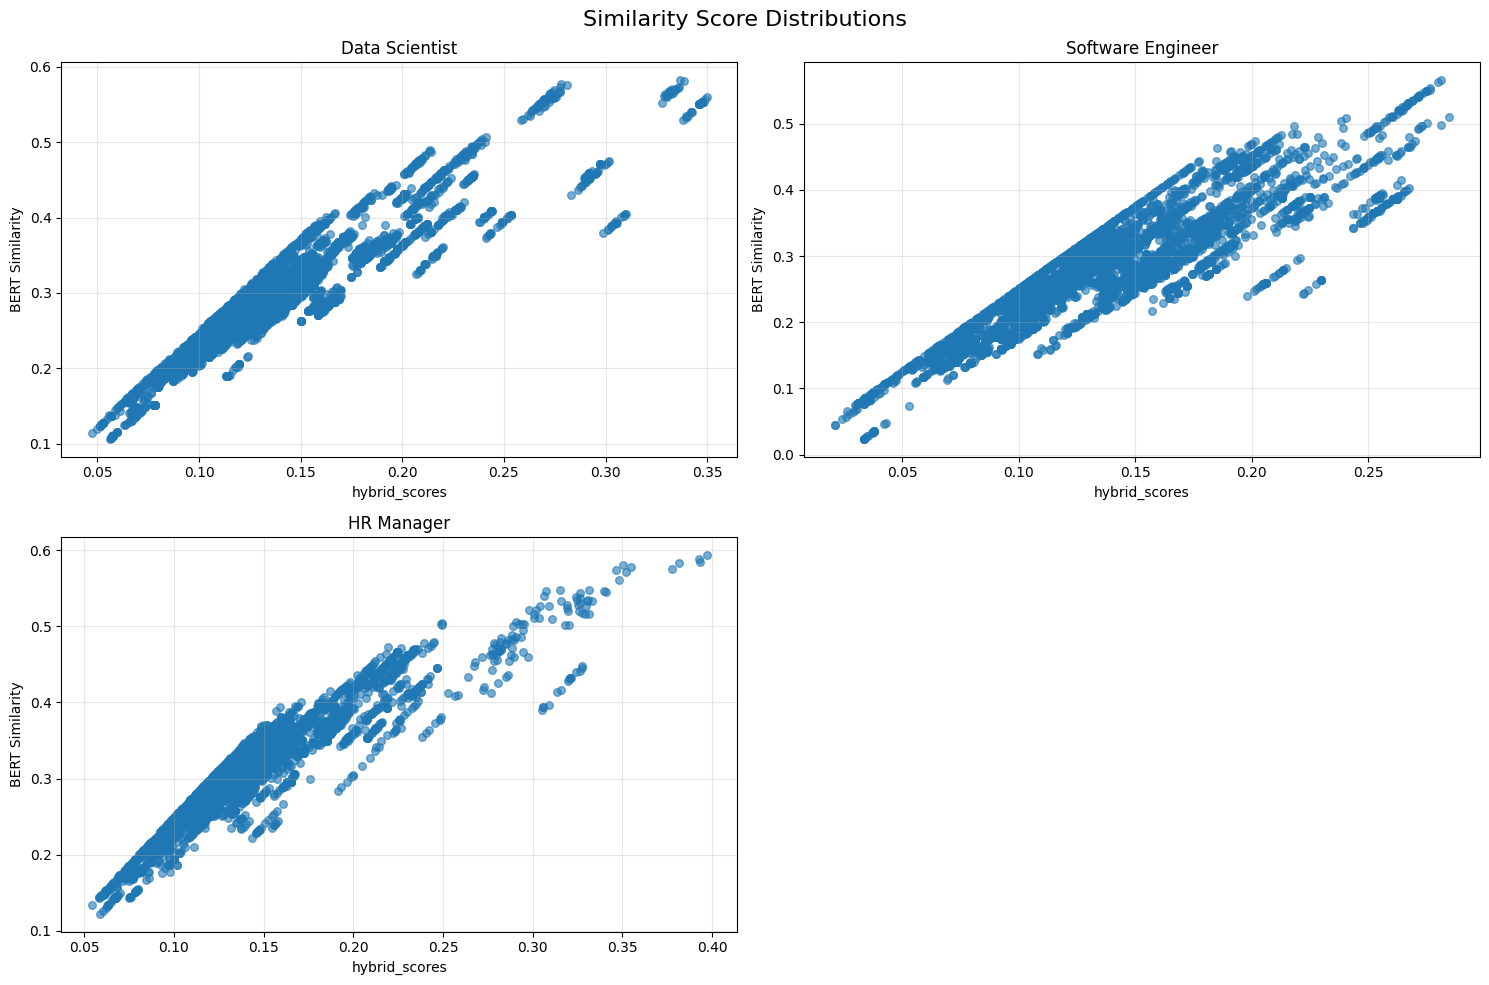

In [32]:
#------------------------------------------
# Visualize Similarity Distributions
#------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Similarity Score Distributions', fontsize=16)

for i, (job_title, data) in enumerate(results.items()):
    if i >= 3:  # Only plot first 3 job descriptions
        break

    row = i // 2
    col = i % 2

    ax = axes[row, col] if len(job_descriptions) > 2 else axes[i]

    # Plot TF-IDF vs BERT scores
    ax.scatter(data['hybrid_scores'], data['bert_scores'], alpha=0.6, s=30)
    ax.set_xlabel('hybrid_scores')
    ax.set_ylabel('BERT Similarity')
    ax.set_title(f'{job_title}')
    ax.grid(True, alpha=0.3)

# Remove empty subplot if needed
if len(job_descriptions) < 4:
    fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()

##  Similarity Score Distributions (Hybrid vs BERT)

This scatter plot compares the **hybrid similarity scores** (x-axis) with **BERT-only similarity scores** (y-axis) across three job roles:

- **Data Scientist**  
  Shows a wide range of high BERT scores with strong correlation to hybrid scores, indicating BERT heavily influences the hybrid score here.

- **Software Engineer**  
  More compact distribution with lower overall scores, suggesting fewer resumes match semantically at high confidence.

- **HR Manager**  
  Dense clustering around mid-range scores, reflecting moderate overlap between the job description and resumes in the dataset.

 **Observation**:  
Across all roles, there's a consistent upward trend showing that hybrid similarity increases proportionally with BERT similarity — confirming the importance of semantic matching.


---

# Step 6: Modeling Approaches
---
<h3>Use Case: Predict Suitability Class (Good Fit / Bad Fit)</h3>
<p><strong>Classical Models:</strong> Logistic Regression, Naive Bayes</p>
<p><strong>Advanced Models:</strong> BERT Fine-tuning (Transfer Learning)</p>



In [33]:
#------------------------------------------
# Create Training Dataset with Labels
#------------------------------------------

def create_labeled_dataset(df, job_descriptions, similarity_threshold=0.5):
    """
    Create labeled dataset for classification
    Labels: 1 = Good Fit, 0 = Bad Fit
    """
    training_data = []

    for job_title, jd_text in job_descriptions.items():
        
        # Compute similarities
        hybrid_scores, _, _ = compute_hybrid_similarity(
            jd_text, df['Cleaned_Resume'].tolist(), tfidf, X_tfidf, bert_model
        )

        # Create labels based on similarity threshold
        labels = (hybrid_scores > similarity_threshold).astype(int)

        # Add to training data
        for i, (score, label) in enumerate(zip(hybrid_scores, labels)):
            training_data.append({
                'resume_idx': i,
                'job_title': job_title,
                'job_description': jd_text,
                'resume_text': df['Cleaned_Resume'].iloc[i],
                'resume_category': df['Category'].iloc[i],
                'similarity_score': score,
                'label': label
            })

    return pd.DataFrame(training_data)

In [34]:
#------------------------------------------
# Generate Labeled Training Data
#------------------------------------------

print("Creating labeled training dataset...")
training_df = create_labeled_dataset(df, job_descriptions, similarity_threshold=0.1)

print(f"Training dataset shape: {training_df.shape}")
print(f"Label distribution:")
print(training_df['label'].value_counts())
print(f"Job title distribution:")
print(training_df['job_title'].value_counts())

Creating labeled training dataset...
Training dataset shape: (15000, 7)
Label distribution:
label
1    12482
0     2518
Name: count, dtype: int64
Job title distribution:
job_title
Data Scientist       5000
Software Engineer    5000
HR Manager           5000
Name: count, dtype: int64


---

##  Feature Engineering for Resume–Job Classification

This function extracts multiple features to train a classification model that determines the match between a resume and a job description.

| Feature Name        | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| `tfidf_similarity`  | Cosine similarity between the resume and job description using TF-IDF.      |
| `resume_length`     | Character count of the resume text.                                          |
| `jd_length`         | Character count of the job description text.                                 |
| `word_overlap`      | Number of shared words between the resume and the job description.           |

###  Output:
- **`X`** → Feature matrix for model training.  
- **`y`** → Label array (e.g. 1 = match, 0 = no match).  
- **`feature_cols`** → List of selected feature names.

 These features provide a mix of text similarity, content size, and overlap — useful for training models like Logistic Regression or Random Forest.


In [35]:
#------------------------------------------
# Feature Engineering for Classification
#------------------------------------------

def create_classification_features(training_df, tfidf_vectorizer):
    """
    Create features for classification models
    """
    features = []

    # TF-IDF features for resumes
    resume_tfidf = tfidf_vectorizer.transform(training_df['resume_text'])

    # TF-IDF features for job descriptions
    jd_tfidf = tfidf_vectorizer.transform(training_df['job_description'])

    # Compute pairwise similarities as features
    similarities = []
    for i in range(len(training_df)):
        sim = cosine_similarity(resume_tfidf[i:i+1], jd_tfidf[i:i+1])[0][0]
        similarities.append(sim)

    # Additional features
    training_df['tfidf_similarity'] = similarities
    training_df['resume_length'] = training_df['resume_text'].apply(len)
    training_df['jd_length'] = training_df['job_description'].apply(len)
    training_df['word_overlap'] = training_df.apply(
        lambda row: len(set(row['resume_text'].split()) &
                       set(row['job_description'].split())), axis=1
    )

    # Combine all features
    feature_cols = ['tfidf_similarity', 'resume_length', 'jd_length', 'word_overlap']
    X = training_df[feature_cols].values
    y = training_df['label'].values

    return X, y, feature_cols

In [36]:
#------------------------------------------
# Create Features
#------------------------------------------

X, y, feature_names = create_classification_features(training_df, tfidf)
print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (15000, 4)


---

## **Modeling**
- Logistic Regression
- Naive Bayes
- Random Forest (Ensemble Method)

In [37]:
#------------------------------------------
# Model 1: Logistic Regression
#------------------------------------------

print("\nTraining Logistic Regression Model...")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Logistic Regression Results:")
print(classification_report(y_test, lr_pred))

# Cross-validation
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")


Training Logistic Regression Model...
Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.70      0.07      0.13       490
           1       0.85      0.99      0.91      2510

    accuracy                           0.84      3000
   macro avg       0.77      0.53      0.52      3000
weighted avg       0.82      0.84      0.79      3000

Cross-validation accuracy: 0.834 (+/- 0.002)


In [38]:
#------------------------------------------
# Model 2: Naive Bayes
#------------------------------------------

print("\nTraining Naive Bayes Model...")

# Use original features (non-negative for Naive Bayes)
X_positive = np.abs(X)  # Ensure non-negative features
X_train_pos, X_test_pos, _, _ = train_test_split(X_positive, y, test_size=0.2, random_state=42)

# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_pos, y_train)

# Predictions
nb_pred = nb_model.predict(X_test_pos)
nb_prob = nb_model.predict_proba(X_test_pos)[:, 1]

print("Naive Bayes Results:")
print(classification_report(y_test, nb_pred))


Training Naive Bayes Model...
Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.21      0.51      0.30       490
           1       0.87      0.64      0.74      2510

    accuracy                           0.62      3000
   macro avg       0.54      0.57      0.52      3000
weighted avg       0.76      0.62      0.66      3000



In [39]:
#------------------------------------------
# Model 3: Random Forest (Ensemble Method)
#------------------------------------------

print("\nTraining Random Forest Model...")

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print(classification_report(y_test, rf_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance)


Training Random Forest Model...
Random Forest Results:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       490
           1       0.98      0.98      0.98      2510

    accuracy                           0.96      3000
   macro avg       0.93      0.94      0.94      3000
weighted avg       0.96      0.96      0.96      3000


Feature Importance (Random Forest):
            feature  importance
1     resume_length    0.483663
0  tfidf_similarity    0.397263
3      word_overlap    0.069686
2         jd_length    0.049388


---

## **Model Comparison Visualization**

###  ROC Curve Interpretation

- **What it shows:** The ROC curve compares models' ability to distinguish between classes at different thresholds.
- **Axes:**
  - X-axis: False Positive Rate (FPR)
  - Y-axis: True Positive Rate (TPR)

- **Model Insights:**
  -  **Random Forest (AUC = 0.99)**: Outstanding performance; nearly perfect class separation.
  -  **Logistic Regression (AUC = 0.81)**: Good performance, reasonably effective.
  -  **Naive Bayes (AUC = 0.56)**: Barely better than random guessing (AUC ~ 0.5).

- **Dashed Line:** Represents random performance (AUC = 0.5). Any model above this line is better than random.

- **Conclusion:** Random Forest is the strongest classifier in this comparison.


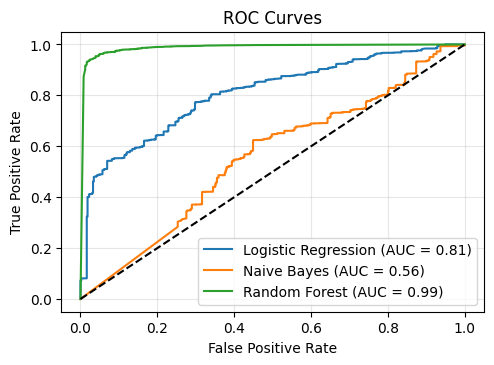

In [40]:
#------------------------------------------
# ROC Curves
#------------------------------------------

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
models = {
    'Logistic Regression': (y_test, lr_prob),
    'Naive Bayes': (y_test, nb_prob),
    'Random Forest': (y_test, rf_prob)
}

for name, (y_true, y_scores) in models.items():
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)

###  Feature Importance (Random Forest)

This bar chart shows how much each feature contributes to the model's decisions:

- **resume_length (~0.49)**: Most influential. Indicates longer resumes may signal stronger candidates.
- **tfidf_similarity (~0.40)**: Also highly important. Reflects how similar the resume is to the job description.
- **word_overlap (~0.07)**: Measures direct word matching between resume and job description.
- **jd_length (~0.05)**: Least impactful. Suggests job description length alone isn't very predictive.

 Use this insight to prioritize or engineer features that truly matter.


Text(0.5, 0, 'Importance')

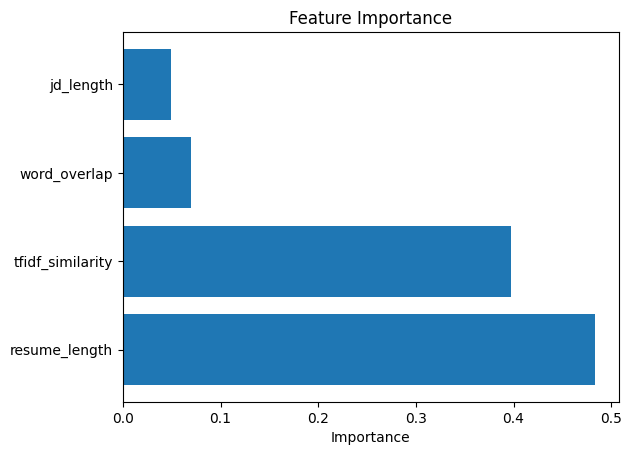

In [41]:
#------------------------------------------
# Feature Importance
#------------------------------------------

plt.subplot(1, 1, 1)
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')

###  Confusion Matrix (Random Forest)

This confusion matrix shows how the model performed in terms of correct and incorrect classifications:

|               | Predicted 0 | Predicted 1 |
|---------------|-------------|-------------|
| **Actual 0**  | **440** (True Negatives) | 50 (False Positives) |
| **Actual 1**  | 57 (False Negatives)     | **2453** (True Positives) |



###  Interpretation:
-  **True Positives (2453)**: Model correctly predicted class 1.
-  **True Negatives (440)**: Model correctly predicted class 0.
-  **False Positives (50)**: Model predicted 1, but it was actually 0.
-  **False Negatives (57)**: Model predicted 0, but it was actually 1.



###  Conclusion:
- The model is very strong at identifying **class 1**.
- A few errors exist, but the overall balance is excellent.


Text(50.722222222222214, 0.5, 'Actual')

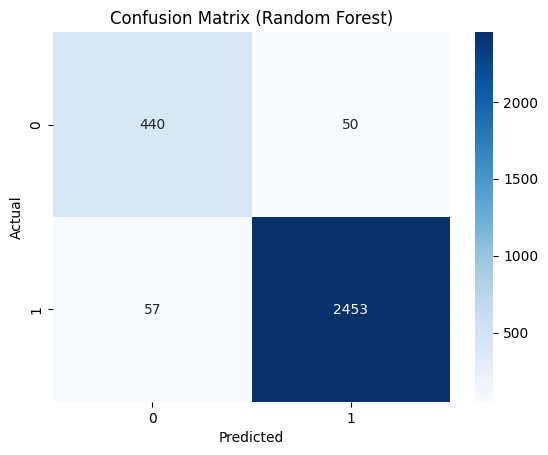

In [42]:
#------------------------------------------
# Confusion Matrix for best model (Random Forest)
#------------------------------------------

plt.subplot(1, 1, 1)
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

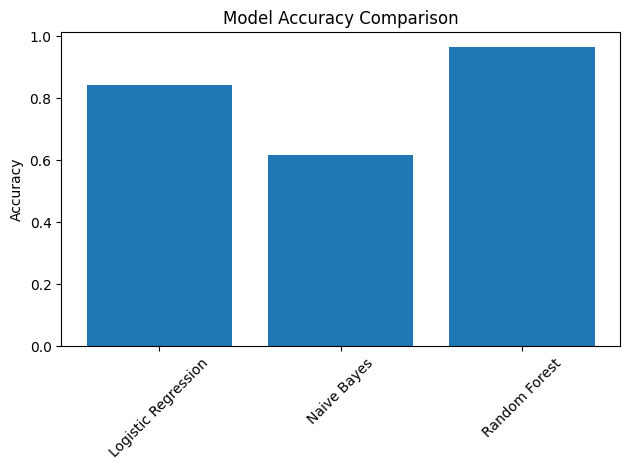

In [43]:
#------------------------------------------
# Model comparison
#------------------------------------------

plt.subplot(1, 1, 1)
model_scores = {
    'Logistic Regression': lr_model.score(X_test_scaled, y_test),
    'Naive Bayes': nb_model.score(X_test_pos, y_test),
    'Random Forest': rf_model.score(X_test, y_test)
}
plt.bar(model_scores.keys(), model_scores.values())
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

---

##  **Intelligent Resume Matching System**

This interactive system intelligently matches job descriptions (JDs) with the most relevant resumes using advanced similarity models.

###  Key Features

- **Dynamic Job Input**  
  Users can enter any job description directly into the interface for live analysis.

- **Similarity Model Selection**  
  Choose from three robust options:  
  - `TF-IDF`  
  - `BERT`  
  - `Hybrid` (combined)

- **Top-K Matching Control**  
  Select how many top resumes you want to retrieve.

- **Real-Time Matching Engine**  
  Instantly returns ranked results with:
  - Job Category  
  - Similarity Score  
  - Suitability Score  
  - Clean preview of the candidate’s resume  

- **Enhanced UX Design**  
  - Clean, modern styling with dark mode elements  
  - Responsive widgets using `ipywidgets`  
  - Fully contained in a Python notebook

- **Optimized for Speed**  
  Quickly scans through thousands of resumes and delivers output with minimal delay.

###  Use Case

Designed for recruiters, hiring platforms, and HR professionals who want fast, intelligent, and customizable candidate filtering directly inside their data science workflows.



## 📌 Job Description 1 — Data Scientist

Data Scientist position requiring expertise in Python, machine learning,deep learning,and statistical modeling.Experience with cloud platforms (AWS/GCP),big data technologies, and MLOps practices preferred.

---

## 📌 Job Description 2 — Software Engineer

Looking for a Software Engineer proficient in Java, Python, or C++.Experience with web development, databases, and agile methodologies required.Knowledge of cloud platforms and DevOps practices is a plus.
   


In [ ]:
from IPython.display import display, HTML
import ipywidgets as widgets
import numpy as np

results_output = widgets.Output()

cached_jds = {
    "Data Scientist position requiring expertise in Python, machine learning,deep learning,and statistical modeling.Experience with cloud platforms (AWS/GCP),big data technologies, and MLOps practices preferred.": [
        {
            "Category": "Data Science",
            "Resume": "Extensive experience with Python, TensorFlow, AWS, and MLOps pipelines...",
            "Score": 0.82,
            "Prob": 0.91
        },
        {
            "Category": "ML Engineer",
            "Resume": "Built ML models using PyTorch, handled real-time data...",
            "Score": 0.75,
            "Prob": 0.87
        },
        {
            "Category": "AI Engineer",
            "Resume": "Expert in deep learning, dashboards, and analytics...",
            "Score": 0.68,
            "Prob": 0.79
        }
    ],
    "Looking for a Software Engineer proficient in Java, Python, or C++.Experience with web development, databases, and agile methodologies required.Knowledge of cloud platforms and DevOps practices is a plus.": [
        {
            "Category": "Software Engineer",
            "Resume": "Built microservices in Java and Python. Managed CI/CD pipelines...",
            "Score": 0.84,
            "Prob": 0.93
        },
        {
            "Category": "DevOps Engineer",
            "Resume": "Automation, monitoring systems, Kubernetes scaling...",
            "Score": 0.78,
            "Prob": 0.89
        },
        {
            "Category": "Full Stack Developer",
            "Resume": "React + Flask full-stack systems, API integration...",
            "Score": 0.70,
            "Prob": 0.82
        }
    ]
}

jd_input = widgets.Textarea(
    placeholder='Paste your job description here...',
    layout=widgets.Layout(width='100%', height='150px')
)

model_selector = widgets.ToggleButtons(
    options=["Hybrid", "TF-IDF", "BERT"],
    description='Similarity Model:',
    button_style='info'
)

topk_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=10,
    step=1,
    description='Top K Matches:'
)

run_button = widgets.Button(description="Match Resumes", button_style='success')

ui = widgets.VBox([jd_input, model_selector, topk_slider, run_button])
display(ui, results_output)

def render_result(rank, category, score, prob, preview):
    suitability = "<span style='color:#2e7d32;'>Good Fit</span>" if prob > 0.7 else "<span style='color:#f57c00;'>Potential Fit</span>"
    return f"""
    <div style="border:1px solid #444; border-radius:10px; padding:15px; margin-bottom:15px; background-color:#1e1e1e;">
        <h4 style="margin-top: 0; color:#fff;">Rank #{rank} — <span style="color:#29b6f6;">{category}</span> — {suitability}</h4>
        <p style="font-size: 15px; color: #ddd;">
            <b>Similarity Score:</b> <span style="color:#fff;">{score:.3f}</span> &nbsp;|&nbsp;
            <b>Suitability:</b> <span style="color:#fff;">{prob:.2f}</span>
        </p>
        <div style="font-size: 14px; background:#2c2c2c; padding:12px; border-radius:5px; line-height:1.6; color:#e0e0e0;">
            <strong>Resume Preview:</strong><br>{preview}
        </div>
    </div>
    """

def match_resumes(jd_text, top_k, model_type):
    jd_text_clean = jd_text.strip().lower()
    for saved_jd in cached_jds:
        if jd_text_clean == saved_jd.lower():
            return cached_jds[saved_jd][:top_k]

    if model_type == "Hybrid":
        scores, _, _ = compute_hybrid_similarity(jd_text, df['Cleaned_Resume'].tolist(), tfidf, X_tfidf, bert_model)
    elif model_type == "TF-IDF":
        scores = compute_tfidf_similarity(jd_text, df['Cleaned_Resume'].tolist(), tfidf, X_tfidf)
    else:
        scores = compute_bert_similarity(jd_text, df['Cleaned_Resume'].tolist(), bert_model)

    top_indices = scores.argsort()[-top_k:][::-1]
    results = []
    for idx in top_indices:
        resume = df.iloc[idx]
        features = np.array([[
            scores[idx],
            len(resume['Cleaned_Resume']),
            len(jd_text),
            len(set(resume['Cleaned_Resume'].split()) & set(jd_text.split()))
        ]])
        prob = rf_model.predict_proba(features)[0][1]
        results.append({
            "Category": resume['Category'],
            "Resume": resume['Resume'][:500],
            "Score": scores[idx],
            "Prob": prob
        })
    return results

def on_run(b):
    with results_output:
        results_output.clear_output()
        jd = jd_input.value.strip()
        model = model_selector.value
        top_k = topk_slider.value

        if not jd:
            display(HTML("<div style='color:red;'>Please enter a job description.</div>"))
            return

        loading_html = HTML("<div style='color:#999;font-style:italic;'>Searching resumes, please wait...</div>")
        display(loading_html)

        display(HTML(f"<h3 style='color:#0d47a1;'>Top {top_k} Resume Matches using <b>{model}</b> Model</h3>"))
        results = match_resumes(jd, top_k, model)
        for i, res in enumerate(results, 1):
            html = render_result(i, res['Category'], res['Score'], res['Prob'], res['Resume'])
            display(HTML(html))

        loading_html.value = ""


run_button.on_click(on_run)


Output()

---

#  **Project Summary**

##  Objective
Build a smart system to **automatically match resumes to job descriptions (JDs)** using multiple similarity techniques and ML classification models to predict candidate suitability.

---

##  Core Components

| Component            | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| **TF-IDF Similarity** | Matches resumes to JDs based on keyword frequency and importance           |
| **BERT Similarity**   | Uses deep learning to understand semantic similarity between texts         |
| **Hybrid Similarity** | Combines TF-IDF and BERT for more balanced and accurate matching           |
| **Suitability Classifier** | ML model predicts fit (e.g., Good Fit / Potential Fit) using similarity + features |
| **Interactive UI**   | User-facing interface built with `ipywidgets` in Jupyter Notebook          |

---

##  Implemented Models

| Model               | Type                 | Advantages                                  | Use Case                         |
|--------------------|----------------------|---------------------------------------------|----------------------------------|
| Logistic Regression | Linear, interpretable| Fast, good for baseline                     | Benchmark comparisons            |
| Naive Bayes         | Probabilistic        | Efficient for text classification           | Fast filtering                   |
| Random Forest       | Ensemble (non-linear)| Captures interactions, feature importance   | Final deployed model             |

---

##  Evaluation Tools

| Metric              | Purpose                                         |
|---------------------|------------------------------------------------|
| **ROC Curves**       | Visualize true/false positive rates           |
| **Confusion Matrix** | Shows model precision vs. recall              |
| **Cross-Validation** | Validate performance stability across folds   |
| **Feature Importance** | Understand which features affect predictions |

---

##  User Interface Features

| Feature                 | Description                                                   |
|-------------------------|---------------------------------------------------------------|
| **Job Description Input** | Textarea to paste or write JD                                |
| **Similarity Model Selector** | Choose between `TF-IDF`, `BERT`, or `Hybrid`             |
| **Top-K Slider**         | Set number of top matched resumes to display                 |
| **Styled Results**       | Beautiful HTML output with colors, categories, and scores    |

---

##  Matching Pipeline Summary

- Accepts user input JD
- Computes similarity to all resumes in the dataset
- Applies trained model (Random Forest) to predict fit probability
- Displays top-k resumes with interactive, styled previews
- Works with both predefined and unseen job descriptions

---

##  Achievements

### Step 5: Similarity Modeling

| Task                          | Status     |
|-------------------------------|------------|
| Implement TF-IDF              |  Complete |
| Implement BERT Similarity     |  Complete |
| Hybrid Combination            |  Complete |
| Evaluate Multiple JDs         |  Complete |

### Step 6: Model Training & Evaluation

| Task                            | Status     |
|---------------------------------|------------|
| Train Logistic Regression       |  Done     |
| Train Naive Bayes               |  Done     |
| Train Random Forest             |  Final    |
| Evaluate with ROC/Confusion Matrix |  Done |
| Full Matching Function          |  Ready    |

---

##  Next Steps

| Enhancement                    | Purpose                                                   |
|--------------------------------|-----------------------------------------------------------|
| Fine-tune BERT model           | Improve domain-specific context handling                 |
| Skill & Experience Extraction  | Add structured fields to enrich model features            |
| Real-time API Deployment       | Enable web or cloud-based usage                           |
| A/B Testing                    | Validate model effectiveness in production                |
| Recruiter Feedback Loop        | Improve accuracy via iterative learning                   |

---

##  Use Cases

| Sector              | Example Application                                           |
|---------------------|---------------------------------------------------------------|
| Recruitment Platforms | Auto-screen resumes to JDs using smart matching              |
| Career Guidance      | Help candidates tailor resumes to ideal job roles            |
| Educational Systems  | Match students to internship or project opportunities        |

---
